In [1]:
import feed
import datetime
import pandas as pd
import numpy as np

In [111]:
data_list = ['本益比(近四季)', '股價淨值比', '成交金額(千)', '還原收盤價', 'EPS_Q', '營業收入淨額_Q', '殖利率', '總市值(億)']
start = datetime.datetime(2004, 1, 1)
end = datetime.datetime.today()
data2_list = ['TWA00', '指數彙編', '指數名稱轉換']
dic = feed.get_from_mongo(elements=data2_list, db='Index')

symbols = dic['指數彙編'][dic['指數彙編'].iloc[:, 0] == '電子上游-IC-通路'].iloc[:, -2].astype(str).values

params = {
        'EPS_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
        '營業收入淨額_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
        '本益比(近四季)': '.mask(data>100, 100)',
        '殖利率': '.mask(data>100, 100)'
}
df = feed.get_from_mongo(
        elements=data_list, 
        db='Fields',
        symbols=symbols,
        start=start, 
        end=end, 
        concat=True,
        ffill=['EPS_Q', '營業收入淨額_Q'],
        zscore=['本益比(近四季)', '股價淨值比', 'EPS_Q', '營業收入淨額_Q', '殖利率'],
        **params)

cap_all = feed.get_from_mongo(
        elements=['總市值(億)'],
        db='Fields',
        start=start,
        end=end,
        concat=True)

idx = df['還原收盤價'].dropna(how='all', axis=0).index
df = df.loc[idx]


Data TWA00 has shape (6045, 34)
Data 指數彙編 has shape (2211, 8)
Data 指數名稱轉換 has shape (1, 22)
Data 本益比(近四季) has shape (4667, 24)
Data 股價淨值比 has shape (4667, 24)
Data 成交金額(千) has shape (4667, 24)
Data 還原收盤價 has shape (4667, 24)
Data EPS_Q has shape (76, 24)
Data 營業收入淨額_Q has shape (76, 24)
Data 殖利率 has shape (4667, 24)
Data 總市值(億) has shape (4667, 24)
Data 總市值(億) has shape (4667, 2211)


<AxesSubplot: >

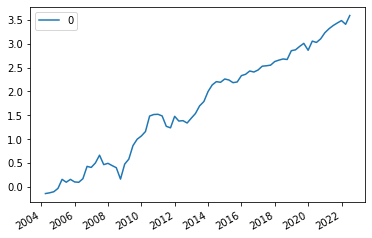

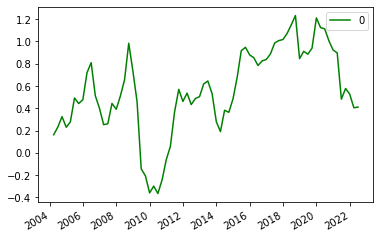

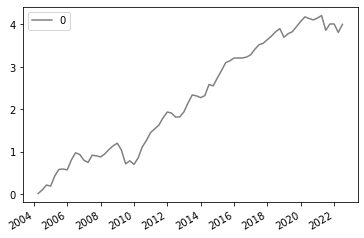

In [140]:
scores = (df['還原收盤價'] > df['還原收盤價'].rolling(120).mean()).astype(int).replace(0, -1) + \
    (df['還原收盤價'] > df['還原收盤價'].rolling(60).mean()).astype(int).replace(0, -1) + \
    df['EPS_Q'] + df['營業收入淨額_Q'] + df['殖利率'] - \
    df['本益比(近四季)'] - df['股價淨值比']

number = 500 * df['總市值(億)'].sum(axis=1)/cap_all.sum(axis=1)
number = number.mask(number<1, 1).round(0).astype(int)
number

rt = df['還原收盤價'].pct_change(60).shift(-61).loc[scores.groupby(pd.Grouper(freq='Q')).tail(1).index]
df_long = pd.DataFrame()
df_short = pd.DataFrame()
for k, v in scores.groupby(pd.Grouper(freq='Q')).tail(1).fillna(0).iterrows():
    length = int(len(v) / 10)
    l = rt.loc[k, v.sort_values()[-length-number.at[k]:-length].index].mean()
    s = -1 * rt.loc[k, v.sort_values()[length:length+number.at[k]].index].mean()
    df_long = pd.concat([df_long, pd.Series({k :l})], axis=0)
    df_short = pd.concat([df_short, pd.Series({k :s})], axis=0)

df_long.cumsum().plot()
df_short.cumsum().plot(color='green')
(df_long.cumsum() + df_short.cumsum()).plot(color='grey')


In [139]:


data_list = ['本益比(近四季)', '股價淨值比', '成交金額(千)', '還原收盤價', 'EPS_Q', '營業收入淨額_Q', '殖利率', '總市值(億)']
start = datetime.datetime(2004, 1, 1)
end = datetime.datetime.today()
data2_list = ['TWA00', '指數彙編', '指數名稱轉換']
dic = feed.get_from_mongo(elements=data2_list, db='Index')
cap_all = feed.get_from_mongo(
        elements=['總市值(億)'],
        db='Fields',
        start=start,
        end=end,
        concat=True)
params = {
        'EPS_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
        '營業收入淨額_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
        '本益比(近四季)': '.mask(data>100, 100)',
        '殖利率': '.mask(data>100, 100)'
}
symbols = dic['指數彙編'][dic['指數彙編'].iloc[:, 0] == '電子上游-IC-通路'].iloc[:, -2].astype(str).values
for s in dic['指數彙編'].iloc[:, 0].unique():
    symbols = dic['指數彙編'][dic['指數彙編'].iloc[:, 0] == s].iloc[:, -2].astype(str).values

    df = feed.get_from_mongo(
            elements=data_list, 
            db='Fields',
            symbols=symbols,
            start=start, 
            end=end, 
            concat=True,
            ffill=['EPS_Q', '營業收入淨額_Q'],
            zscore=['本益比(近四季)', '股價淨值比', 'EPS_Q', '營業收入淨額_Q', '殖利率'],
            **params)


        
    idx = df['還原收盤價'].dropna(how='all', axis=0).index
    df = df.loc[idx]
    
scores = (df['還原收盤價'] > df['還原收盤價'].rolling(120).mean()).astype(int).replace(0, -1) + \
    (df['還原收盤價'] > df['還原收盤價'].rolling(60).mean()).astype(int).replace(0, -1) + \
    df['EPS_Q'] + df['營業收入淨額_Q'] + df['殖利率'] - \
    df['本益比(近四季)'] - df['股價淨值比']

number = 500 * df['總市值(億)'].sum(axis=1)/cap_all.sum(axis=1)
number = number.mask(number<1, 1).round(0).astype(int)
number

rt = df['還原收盤價'].pct_change(60).shift(-61).loc[scores.groupby(pd.Grouper(freq='Q')).tail(1).index]
df_long = pd.DataFrame()
df_short = pd.DataFrame()
for k, v in scores.groupby(pd.Grouper(freq='Q')).tail(1).fillna(0).iterrows():
    length = int(len(v) / 10)
    l = rt.loc[k, v.sort_values()[-length-number.at[k]:-length].index].mean()
    s = -1 * rt.loc[k, v.sort_values()[length:length+number.at[k]].index].mean()
    df_long = pd.concat([df_long, pd.Series({k :l})], axis=0)
    df_short = pd.concat([df_short, pd.Series({k :s})], axis=0)

df_long.cumsum().plot()
df_short.cumsum().plot(color='green')
(df_long.cumsum() + df_short.cumsum()).plot(color='grey')


nan

<AxesSubplot: >

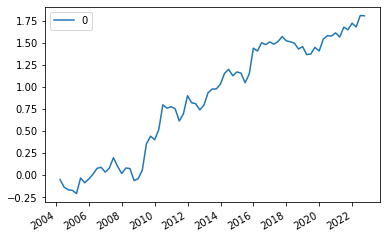

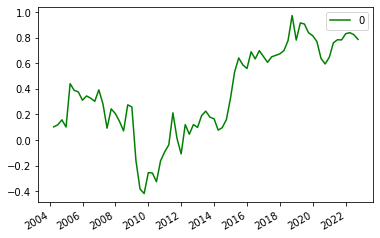

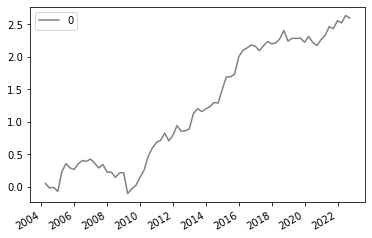

In [30]:
v.sort_values()[:5].index
v.sort_values()[-5:].index

Index(['3056', '4930', '1436', '2609', '1439'], dtype='object')

In [23]:
df_cut

,0
1101,3
1102,3
1103,3
1104,3
1108,3
...,...
9951,3
9955,4
9958,3
9960,5


In [21]:
pd.cut(分數.resample('BQ').ffill().iloc[-1], 5)

1101    (-4.463, -0.602]
1102       (3.26, 7.121]
1103                 NaN
1104       (3.26, 7.121]
1107                 NaN
              ...       
9951    (-4.463, -0.602]
9955                 NaN
9958    (-4.463, -0.602]
9960       (3.26, 7.121]
9962       (3.26, 7.121]
Name: 2022-12-30 00:00:00, Length: 2211, dtype: category
Categories (5, interval[float64, right]): [(-12.205, -8.325] < (-8.325, -4.463] < (-4.463, -0.602] < (-0.602, 3.26] < (3.26, 7.121]]

In [20]:
(df1['本益比(近四季)'].subtract(df1['本益比(近四季)'].mean(axis=1), axis=0)).divide(df1['本益比(近四季)'].std(ddof=0, axis=1), axis=0)

,1101,1102,1103,1104,1107,1108,1109,1110,1113,1201,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
日期,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.454539,-0.618736,-0.703053,-0.609860,NaN,-0.521105,-0.445664,2.190360,NaN,0.251063,...,0.969979,-1.031447,0.890099,3.321986,-0.281467,-0.445664,NaN,0.517328,0.211123,-0.556607
2015-01-06,-0.458075,-0.618131,-0.693713,-0.604793,NaN,-0.520319,-0.444737,2.191743,NaN,0.253285,...,0.991322,-1.027163,0.849050,3.338812,-0.275789,-0.449183,NaN,0.506708,0.231055,-0.551441
2015-01-07,-0.461464,-0.612542,-0.696968,-0.608099,NaN,-0.519229,-0.448134,2.160187,NaN,0.236162,...,1.004883,-1.030229,0.836031,3.333265,-0.279282,-0.439247,NaN,0.489440,0.205057,-0.554777
2015-01-08,-0.465013,-0.611809,-0.696327,-0.607360,NaN,-0.522842,-0.451668,2.146167,NaN,0.237826,...,0.980700,-1.034402,0.793869,3.333876,-0.282631,-0.438323,NaN,0.478037,0.233377,-0.553980
2015-01-09,-0.472321,-0.614622,-0.699112,-0.610175,NaN,-0.525684,-0.441193,2.164684,NaN,0.239181,...,0.941790,-1.037076,0.803936,3.329769,-0.281105,-0.441193,NaN,0.483760,0.230287,-0.556812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-21,0.380590,-0.533868,NaN,-0.608517,NaN,-0.468549,-0.557196,3.693169,NaN,0.021339,...,-0.771814,-0.566527,0.077326,NaN,NaN,-0.370572,NaN,0.375925,-0.636511,-0.655174
2022-11-22,0.375028,-0.532883,NaN,-0.607762,NaN,-0.472043,-0.556283,3.707155,NaN,0.024032,...,-0.771560,-0.565643,0.084871,NaN,NaN,-0.373764,NaN,0.323549,-0.635842,-0.659242
2022-11-23,0.373527,-0.536120,NaN,-0.610757,NaN,-0.475476,-0.559444,3.690240,NaN,0.032993,...,-0.774027,-0.564109,0.079641,NaN,NaN,-0.382179,NaN,0.308219,-0.634081,-0.657406


In [8]:

df1 = df.loc[outsample:]
long = (df1['本益比(近四季)'] < q1['本益比(近四季)']) & (df1['股價淨值比'] < q1['股價淨值比']) & \
        (df1['成交金額(千)'].ge(df1['成交金額(千)'].median(axis=1), axis=0)) &\
        (df1['還原收盤價'] > df1['還原收盤價'].rolling(60).mean()) &\
        (df1['還原收盤價'] > df1['還原收盤價'].rolling(120).mean()) &\
        (df1['EPS_Q'] > q3['EPS_Q']) & (df1['營業收入淨額_Q'] > q3['營業收入淨額_Q']) &\
        (df1['殖利率'] > q3['殖利率'])
long = long.shift(1)

short = (df1['本益比(近四季)'] > q3['本益比(近四季)']) & (df1['股價淨值比'] > q3['股價淨值比']) & \
        (df1['成交金額(千)'].ge(df1['成交金額(千)'].median(axis=1), axis=0)) &\
        (df1['還原收盤價'] < df1['還原收盤價'].rolling(60).mean()) &\
        (df1['還原收盤價'] < df1['還原收盤價'].rolling(120).mean()) &\
        (df1['EPS_Q'] < q1['EPS_Q']) & (df1['營業收入淨額_Q'] < q1['營業收入淨額_Q']) &\
        (df1['殖利率'] < q1['殖利率'])
short = short.shift(1)

In [387]:
df1['本益比(近四季)'].subtract(df1['本益比(近四季)'].mean(axis=1), axis=0)#.divide(df1.std())

,1101,1102,1103,1104,1107,1108,1109,1110,1113,1201,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
日期,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-10.242560,-13.942560,-15.842560,-13.742560,NaN,-11.742560,-10.042560,49.357440,NaN,5.657440,...,21.857440,-23.242560,20.057440,74.857440,-6.342560,-10.042560,NaN,11.657440,4.757440,-12.542560
2015-01-06,-10.303076,-13.903076,-15.603076,-13.603076,NaN,-11.703076,-10.003076,49.296924,NaN,5.696924,...,22.296924,-23.103076,19.096924,75.096924,-6.203076,-10.103076,NaN,11.396924,5.196924,-12.403076
2015-01-07,-10.385204,-13.785204,-15.685204,-13.685204,NaN,-11.685204,-10.085204,48.614796,NaN,5.314796,...,22.614796,-23.185204,18.814796,75.014796,-6.285204,-9.885204,NaN,11.014796,4.614796,-12.485204
2015-01-08,-10.453616,-13.753616,-15.653616,-13.653616,NaN,-11.753616,-10.153616,48.246384,NaN,5.346384,...,22.046384,-23.253616,17.846384,74.946384,-6.353616,-9.853616,NaN,10.746384,5.246384,-12.453616
2015-01-09,-10.621381,-13.821381,-15.721381,-13.721381,NaN,-11.821381,-9.921381,48.678619,NaN,5.378619,...,21.178619,-23.321381,18.078619,74.878619,-6.321381,-9.921381,NaN,10.878619,5.178619,-12.521381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-21,8.157368,-11.442632,NaN,-13.042632,NaN,-10.042632,-11.942632,79.157368,NaN,0.457368,...,-16.542632,-12.142632,1.657368,NaN,NaN,-7.942632,NaN,8.057368,-13.642632,-14.042632
2022-11-22,8.013502,-11.386498,NaN,-12.986498,NaN,-10.086498,-11.886498,79.213502,NaN,0.513502,...,-16.486498,-12.086498,1.813502,NaN,NaN,-7.986498,NaN,6.913502,-13.586498,-14.086498
2022-11-23,8.007265,-11.492735,NaN,-13.092735,NaN,-10.192735,-11.992735,79.107265,NaN,0.707265,...,-16.592735,-12.092735,1.707265,NaN,NaN,-8.192735,NaN,6.607265,-13.592735,-14.092735


In [394]:
df1['EPS_Q'].min(axis=1)

日期
2015-01-05   -7.700000e+01
2015-01-06   -7.700000e+01
2015-01-07   -7.700000e+01
2015-01-08   -7.700000e+01
2015-01-09   -7.700000e+01
                  ...     
2022-11-21   -2.341872e+15
2022-11-22   -2.341872e+15
2022-11-23   -2.341872e+15
2022-11-24   -2.341872e+15
2022-11-25   -2.341872e+15
Length: 1933, dtype: float64

<AxesSubplot: xlabel='日期'>

c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  func(*args, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  func(*args, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


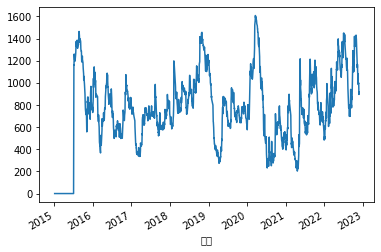

In [321]:
#(df['還原收盤價'] < df['還原收盤價'].rolling(120).mean()).sum().sum()
(df1['還原收盤價'] < df1['還原收盤價'].rolling(120).mean()).sum(axis=1).plot()

<AxesSubplot: xlabel='日期'>

c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  func(*args, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  func(*args, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


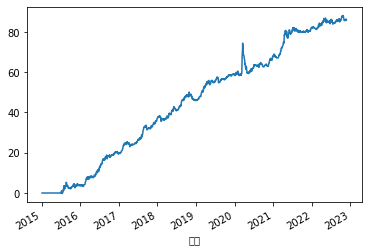

In [338]:
((long - short) * df1['還原收盤價'].pct_change().shift(-1)).sum(axis=1).cumsum().plot()

In [342]:
(long - short).diff().abs().sum().sum()

37375

In [355]:
((long - short).replace(to_replace=0, method='ffill')* df1['還原收盤價'].pct_change().shift(-1))

,1101,1102,1103,1104,1107,1108,1109,1110,1113,1201,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
日期,,,,,,,,,,,,,,,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-21,0.006088,-0.002436,0.0,0.0,NaN,-0.004717,0.0,0.002793,NaN,-0.00266,...,-0.004938,-0.003401,0.004274,NaN,NaN,-0.0048,NaN,0.039397,-0.005964,-0.003067
2022-11-22,-0.001531,-0.004884,0.002907,0.0,NaN,0.0,0.0,-0.0,NaN,-0.013263,...,-0.004914,0.005688,0.0,NaN,NaN,-0.012862,NaN,0.00965,-0.005929,0.003077
2022-11-23,-0.015291,0.008589,0.011594,0.0,NaN,0.0,0.006472,-0.0,NaN,-0.007853,...,-0.002445,0.022624,0.008511,NaN,NaN,-0.001629,NaN,-0.004872,0.003929,0.0


In [366]:
ls = long-short
#ls = ls.mask(ls==1, 500000)
#ls = ls.mask(ls==-1, -500000)
ls.replace(to_replace=0, method='ffill', inplace=True)


<AxesSubplot: xlabel='日期'>

c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  func(*args, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  func(*args, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ChastLai\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


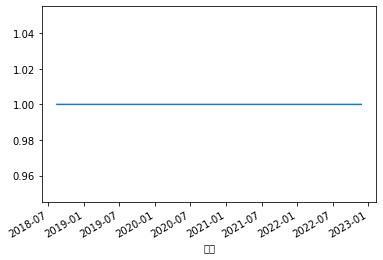

In [380]:
ls.loc[:, '1103'].plot()